# Layers

gdsfactory includes a generic example Technology in `gdsfactory.tech` that you can use as an inspiration to create your own.

![](https://i.imgur.com/GUb1Kav.png)


A GDS has different layers to describe the different fabrication process steps.

GDS layers have 2 integer numbers: GDSlayer, GDSpurpose

Klayout shows Layers with a color, style and transparency when showing GDS layouts.

In [1]:
import gdsfactory as gf

# gf.CONF.plotter = 'holoviews'

2022-06-30 06:09:04.617 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.12.4


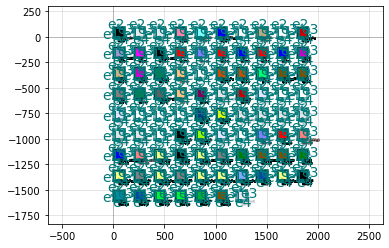

layerset: uid 0, ports [], aliases [], 0 polygons, 174 references

In [2]:
c = gf.layers.LAYER_COLORS.preview()
c

In [3]:
layer_wg = gf.LAYER.WG
print(layer_wg)

(1, 0)


### Remove layers

You can remove layers using the `remove_layers()` function.

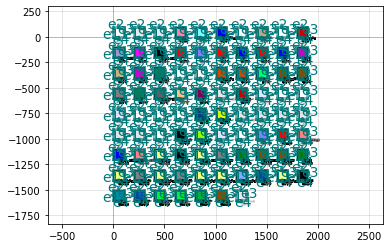

layerset: uid 0, ports [], aliases [], 0 polygons, 174 references

In [4]:
removed = c.remove_layers(layers=(gf.LAYER.WG, gf.LAYER.WGN))
removed

### Remap layers

You can remap (change the polygons from one layer to another layer) using the `remap_layer`, which will return a new `Component`

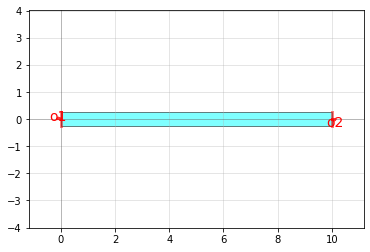

straight_layer2__0: uid 432, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [5]:
c = gf.components.straight(layer=(2, 0))
c

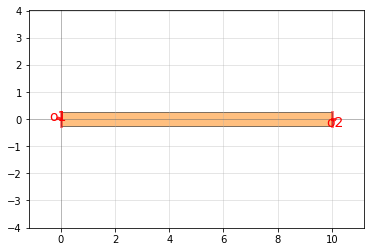

straight_layer2__0: uid 432, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [6]:
remap = c.remap_layers(layermap={(2, 0): gf.LAYER.WGN})
remap

### Extract layers

You can also extract layers using the `extract` function. This function returns a new flattened Component that contains the extracted layers.
A flat Component does not have references, and all the polygons are absorbed by the top cell.

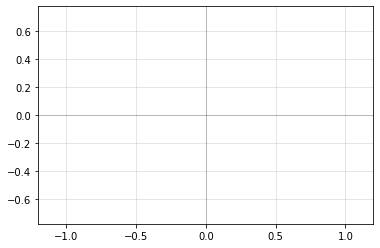

straight_layer2__0_[[41, 0]]: uid 434, ports [], aliases [], 0 polygons, 0 references

In [7]:
extract = c.extract(layers=(gf.LAYER.M1,))
extract

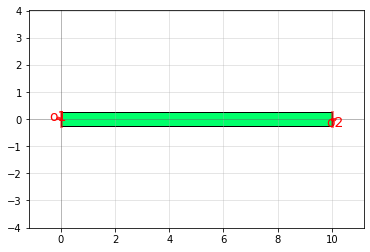

straight_layer41__0: uid 435, ports ['o1', 'o2'], aliases [], 4 polygons, 0 references

In [8]:
import gdsfactory as gf

c = gf.components.straight(layer=(41, 0))
c

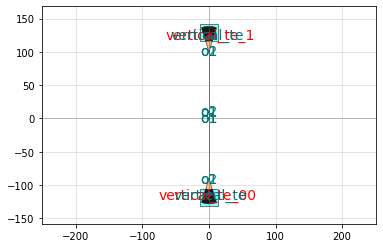

straight_70053cf8_move__268c7941: uid 442, ports ['vertical_te_00', 'vertical_te_1'], aliases [], 0 polygons, 5 references

In [9]:
cross_section = gf.cross_section.nitride
wg = gf.components.straight(cross_section=cross_section)
gc = gf.components.grating_coupler_elliptical_te(
    layer=(34, 0), cross_section=cross_section
)
wg_gc = gf.routing.add_fiber_single(
    component=wg,
    grating_coupler=gc,
    cross_section=gf.cross_section.nitride,
    with_loopback=False,
)

# Loopback is an alignment structure where two gratings are connected back to back
wg_gc

## LayerStack

Each layer also includes the information of thickness and position of each layer.

This LayerStack can be used for:

- render a 3D image
- FDTD simulations

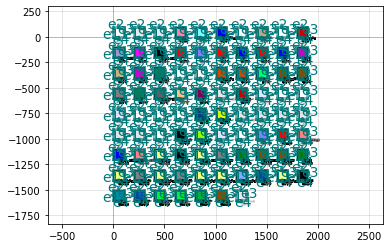

layerset: uid 452, ports [], aliases [], 0 polygons, 174 references

In [10]:
c = gf.layers.LAYER_COLORS.preview()
c

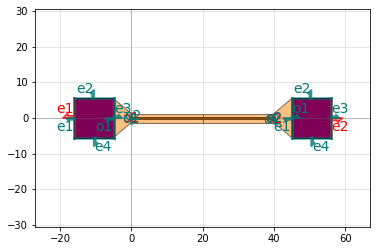

straight_heater_metal_u_d99b3f2a: uid 459, ports ['o1', 'o2', 'e1', 'e2'], aliases [], 0 polygons, 5 references

In [11]:
from gdsfactory.tech import LayerStack, LayerLevel, LAYER


def get_layer_stack_generic(
    thickness_silicon_core: float = 220e-3, thickness_cladding: float = 3.0
) -> LayerStack:
    """Returns generic LayerStack.
    based on paper https://www.degruyter.com/document/doi/10.1515/nanoph-2013-0034/html
    """
    return LayerStack(
        layers=dict(
            core=LayerLevel(
                layer=LAYER.WG,
                thickness=thickness_silicon_core,
                zmin=0.0,
                material="si",
            ),
            clad=LayerLevel(
                layer=LAYER.WGCLAD,
                thickness=thickness_cladding,
                zmin=0.0,
                material="sio2",
            ),
            slab150=LayerLevel(
                layer=LAYER.SLAB150,
                thickness=150e-3,
                zmin=0,
                material="si",
            ),
            slab90=LayerLevel(
                layer=LAYER.SLAB90,
                thickness=90e-3,
                zmin=0.0,
                material="si",
            ),
            nitride=LayerLevel(
                layer=LAYER.WGN,
                thickness=350e-3,
                zmin=220e-3 + 100e-3,
                material="sin",
            ),
            ge=LayerLevel(
                layer=LAYER.GE,
                thickness=500e-3,
                zmin=thickness_silicon_core,
                material="ge",
            ),
            via_contact=LayerLevel(
                layer=LAYER.VIAC,
                thickness=1100e-3,
                zmin=90e-3,
                material="Aluminum",
            ),
            metal1=LayerLevel(
                layer=LAYER.M1,
                thickness=750e-3,
                zmin=thickness_silicon_core + 1100e-3,
                material="Aluminum",
            ),
            heater=LayerLevel(
                layer=LAYER.HEATER,
                thickness=750e-3,
                zmin=thickness_silicon_core + 1100e-3,
                material="TiN",
            ),
            viac=LayerLevel(
                layer=LAYER.VIA1,
                thickness=1500e-3,
                zmin=thickness_silicon_core + 1100e-3 + 750e-3,
                material="Aluminum",
            ),
            metal2=LayerLevel(
                layer=LAYER.M2,
                thickness=2000e-3,
                zmin=thickness_silicon_core + 1100e-3 + 750e-3 + 1.5,
                material="Aluminum",
            ),
        )
    )


layer_stack220 = get_layer_stack_generic(thickness_silicon_core=0.220)

c = gf.components.straight_heater_metal(length=40)
c

In [12]:
scene = gf.export.to_3d(
    component=c, layer_colors=gf.layers.LAYER_COLORS, layer_stack=layer_stack220
)
scene.show()

In [13]:
# lets assume we have 9um silicon instead of 0.220um, You will see a much thicker waveguide under the metal heater.
layer_stack9000 = get_layer_stack_generic(thickness_silicon_core=9.0)
scene = gf.export.to_3d(
    component=c, layer_colors=gf.layers.LAYER_COLORS, layer_stack=layer_stack9000
)
scene.show()

## 3D rendering

To render components in 3D you will need to define two things:

1. LayerStack: for each layer contains thickness of each material and z position
2. LayerColors: for each layer contains colors (this file is the same that Klayout uses). You can load it with `gf.layers.load_lyp()`

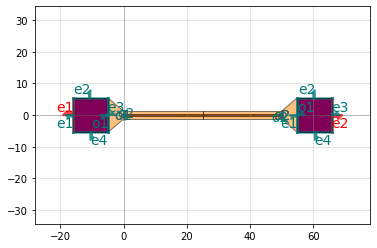

straight_heater_metal_u_d92d12b4: uid 470, ports ['o1', 'o2', 'e1', 'e2'], aliases [], 0 polygons, 5 references

In [14]:
heater = gf.components.straight_heater_metal(length=50)
heater

In [15]:
scene = gf.export.to_3d(component=heater, layer_colors=gf.layers.LAYER_COLORS)
scene.show()